In [ ]:
import numpy as np
def get_data():
 data_file = "datatimeseriesnorm.csv"
 f = open(data_file)
 data = f.read()
 f.close()
 lines = data.split('\n')
 header = lines[0].split(',')
 lines = lines[1:]
 temperatures=[]
 for line in lines:
  if line:
    linedata = line.split(',')
    linedata = linedata[1:13]
    for item in linedata:
      if item:
        temperatures.append(float(item))
 series = np.asarray(temperatures)
 time = np.arange(len(temperatures), dtype="float32")
 return time, series

In [ ]:
# datayı normalleştirelim.
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std

In [ ]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
 plt.plot(time[start:end], series[start:end], format)
 plt.xlabel("Time")
 plt.ylabel("Value")
 plt.grid(True)

In [ ]:
# veriyi bölelim.
split_time = 100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [ ]:
# penceremizi oluşturalım.
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 series = tf.expand_dims(series, axis=-1)
 dataset = tf.data.Dataset.from_tensor_slices(series)
 dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
 dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
 dataset = dataset.shuffle(shuffle_buffer).map(
 lambda window: (window[:-1], window[-1]))
 dataset = dataset.batch(batch_size).prefetch(1)
 return dataset

In [ ]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size,batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
 tf.keras.layers.SimpleRNN(100, return_sequences=True,
 input_shape=[None, 1]),
 tf.keras.layers.SimpleRNN(100),
 tf.keras.layers.Dense(1)
])
'''
# simplernn
model = tf.keras.models.Sequential([
 tf.keras.layers.SimpleRNN(100, input_shape=[None, 1],
 return_sequences=True),
 tf.keras.layers.SimpleRNN(100),
 tf.keras.layers.Dense(1)
])

#gru
model = tf.keras.models.Sequential([
 tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
 tf.keras.layers.GRU(100),
 tf.keras.layers.Dense(1)
])

# lstm
model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True),
 tf.keras.layers.LSTM(100),
 tf.keras.layers.Dense(1)
])

# dropout
model = tf.keras.models.Sequential([
 tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
 dropout=0.1, recurrent_dropout=0.1),
 tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
 tf.keras.layers.Dense(1),
])

# bidirectional 
model = tf.keras.models.Sequential([
 tf.keras.layers.Bidirectional(
 tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True,
 dropout=0.1, recurrent_dropout=0.1)),
 tf.keras.layers.Bidirectional(
 tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
 tf.keras.layers.Dense(1),
])

'''

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1,
 validation_data=valid_dataset)


Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


7/7 [==============================] - 3s 166ms/step - loss: 0.5809 - mae: 1.0373 - val_loss: 0.5468 - val_mae: 0.9517
Epoch 2/100
7/7 [==============================] - 1s 113ms/step - loss: 0.5655 - mae: 1.0194 - val_loss: 0.5333 - val_mae: 0.9356
Epoch 3/100
7/7 [==============================] - 1s 115ms/step - loss: 0.5425 - mae: 0.9922 - val_loss: 0.5172 - val_mae: 0.9163
Epoch 4/100
7/7 [==============================] - 1s 107ms/step - loss: 0.5169 - mae: 0.9607 - val_loss: 0.5004 - val_mae: 0.8958
Epoch 5/100
7/7 [==============================] - 1s 107ms/step - loss: 0.4905 - mae: 0.9284 - val_loss: 0.4837 - val_mae: 0.8754
Epoch 6/100
7/7 [==============================] - 1s 115ms/step - loss: 0.4655 - mae: 0.8958 - val_loss: 0.4672 - val_mae: 0.8552
Epoch 7/100
7/7 [==============================] - 1s 111ms/step - loss: 0.4403 - mae: 0.8647 - val_loss: 0.4520 - val_mae: 0.8364
Epoch 8/100
7/7 [==============================] - 1s 105ms/step - loss: 0.4173 - mae: 0.8346 -

In [ ]:
def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast

In [ ]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

51/51 [==============================] - 1s 9ms/step


In [ ]:
results = forecast[split_time - window_size:-1, -1]

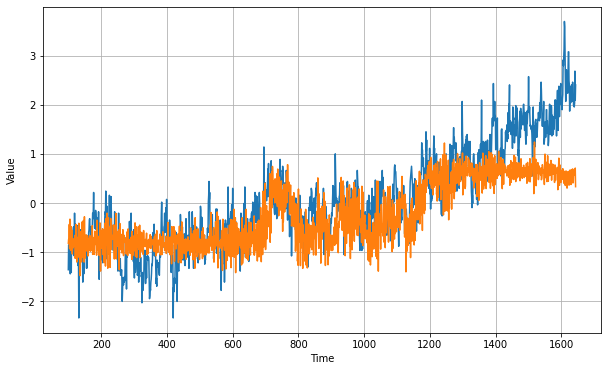

In [ ]:
# Optimize edilmiş CNN tahminleri
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

<Figure size 432x288 with 0 Axes>

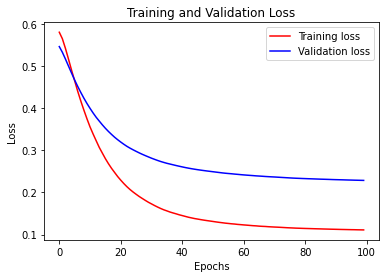

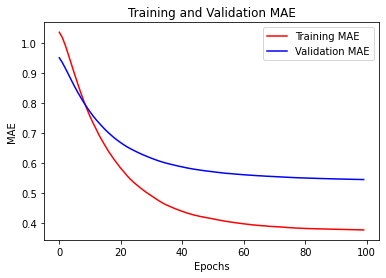

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss ve mae değerlerini görselleştirelim.
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

# Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()

# MAE
plt.plot(epochs, history.history['mae'], 'r', label='Training MAE')
plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.figure()